In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

### Reinforcement Learning for Algorithmic Trading
-----

We will re-design the simple trend moving strategy in a way that fits with an RL API
with the goal of reaching Q-learning in steps. 

|time stamp | SPY [Close] | Fast SMA | Slow SMA | Return|
|---:|:-------------|:-----------|:------|:------|
| t-1 | # | #       | #   | #   |
| t | #  | 1.5  | 1.3  | #   |
| t+1 | #  | # | # | #   |
| t+2 | #  | # | # | #   |

Lets assume that at time `t` we are not invested, given the `Fast SMA` > `Slow SMA` we decide to invest at time `t+1` at which we also received a reward (return at `t+1`): 

This is a Markov Decision Process: {`s(t)`, `a(t)`, `s(t+1)`, `r(t+1)`} where `s` are states `a(t)` is the action we performed (buying the stock by being invested). 

In the trend following strategy:

- our state can be represented by a 2-vector: (`Fast SMA`, `Slow SMA`)
- Reward is just the return: a scalar 
- Actions are: `Buy`, `Sell`, or `Do Nothing`. 


In particular;

- We buy when we are not invested + state: `Fast SMA > Slow SMA` 

- We do nothing when: 
    - Already invested + state: `Fast SMA > Slow SMA`
    - Not invested + state: `Fast SMA < Slow SMA`

- Sell when invested + State: `Fast SMA < Slow SMA`


In [10]:
df = pd.read_csv('SPY.csv', index_col = 0, parse_dates = True)

# make fast/slow sma features as states 

df['F_SMA'] = df['Close'].rolling(16).mean()
df['S_SMA'] = df['Close'].rolling(33).mean()

feats = ['F_SMA', 'S_SMA']

# Log returns as rewards

df['Log_return'] = np.log(df['Close'].pct_change()+1)


In [11]:
# train val split 

N_val =1000 
train_data = df[:-N_val].copy()
val_data = df[-N_val:].copy()


In [12]:
# Environment Class 

class Env:
    def __init__(self, df): # constructor 
        
        self.df = df
        self.n = len(df) # to keep track of the end of the df 
        self.current_idx = 0
        self.action_space = [0,1,2] # BUY, SELL, HOLD
        self.invested = 0
        
        self.states = self.df[feats].to_numpy() # F_SMA and S_SMA's of the df as states 
        self.rewards = self.df['Log_return'].to_numpy() 
        
        self.total_buy_and_hold = 0
        
    def reset(self):
        
        self.current_idx = 0
        self.total_buy_and_hold = 0
        self.invested = 0
        
        return self.states[self.current_idx]
    
    def step(self, action):
        
        # need to return next state, reward, done 
        self.current_idx += 1
        
        if self.current_idx >= self.n: 
            raise Exception('Episode is already done')
        
        if action == 0: # BUY
            self.invested = 1
        elif action ==1: # SELL
            self.invested = 0
            
        # compute reward 
        
        if self.invested: 
            reward = self.rewards[self.current_idx]
        else:
            reward = 0
            
        # state transition
        next_state = self.states[self.current_idx]
        
        # baseline strategy
        
        self.total_buy_and_hold += self.rewards[self.current_idx]
        
        # done flag 
        
        done = (self.current_idx == self.n - 1)
        
        return next_state, reward, done  
        
        

In [13]:
class Agent:
    
    def __init__(self):
        
        self.is_invested = False
        
    def act(self, state):
        
        assert(len(state) == 2) # (F_SMA, S_SMA)
        
        if state[0] > state[1] and not self.is_invested:
            
            self.is_invested = True
            return 0 # Buy
        
        if state[0] < state[1] and self.is_invested:
            
            self.is_invested = False
            return 1 # Sell
        
        return 2 # Do nothing

In [14]:
# Play one episode

def play_one_episode(agent, env):
    
    state = env.reset()
    
    done = False 
    
    total_reward = 0
    
    agent.is_invested = False
    
    while not done:
        
        action = agent.act(state)
        
        next_state, reward, done = env.step(action)
        
        total_reward += reward
        
        state = next_state
        
    return total_reward

In [15]:
train_env = Env(train_data)
val_env = Env(val_data)

In [16]:
agent = Agent()

In [17]:
train_reward = play_one_episode(agent, train_env)

In [18]:
val_reward = play_one_episode(agent, val_env)

In [19]:
# compare train_reward with total buy and hold strategy

train_reward, train_env.total_buy_and_hold

(0.43459304796457127, 0.5970866514889426)

In [20]:
# compare val_reward with total buy and hold strategy

val_reward, val_env.total_buy_and_hold

(0.08889132894199075, 0.19307543946998412)

Notice that we have got the same train and val cumulative returns we obtained in `Algo_Trading.ipynb`. 

Here we just implemented the trend following strategy in a more realistic way where an agent interacts with an environment and makes decisions observing the state of the environment. In this implementation there is no learning component attributed to the agent. Next we will implement the algorithmic trading strategy in a Q-learning setup.

#### Q-learning implementation
-----

- Unlike the trend following implementation above, our Q-learning agent will improve using its experiences

- The main tool we will use is the Q-table, $Q(s,a)$: 

|States | Action 0 | Action 1 | Action 2 |
|---:|:-------------|:-----------|:------|
| State-0 | # | #       | #   | 
| State-1 | #  | #  | #  |
| State-2 | #  | # | # | 
| ... | #  | # | # | 

**What is Q?**

- $Q(s,a) =$ expected return for doing action `a` while in state `s`

Note that this is not the financial returns. Return in RL = `sum of future rewards` and in our context rewards are `financial log returns`. 

To summarize, so $Q$ for state `s` and action `a` represents the sum of future rewards I will expect to get in the next timestep, timestep after that and so on...

- Since we want to maximize future rewards in RL, our policy should be to choose whatever action `a` that yields the maximum Q for a given state `s`.

That is our policy should be to take the argmax over $Q(s,a)$ for all possible actions `a` assuming that Q-table has the right values:

$$\textrm{Optimal action:} a^{*} = \textrm{argmax}_a \,Q(s,a)$$


How do we make sure that the Q-table has the right values? The answer is: Q-learning! 

One key point to notice that Q-learning recursive equation for the RL return is nothing but EWMA:

$$ G(t) = R(t+1) + \gamma G(t+1) $$

- We can (better) estimate $Q$ by taking one step, getting the **true reward** $r$, and estimating the rest using $Q$ again:

$$ \textrm{Estimated Future Return} \approx r + \gamma\,\textrm{max}_{a'} Q(s',a') $$

- We call this the better estimate of $Q$ (the target) and rename it as $Y$: 

$$ Y = r + \gamma\, \textrm{max}_a' Q(s',a') $$

- We update Q by using the EWMA utilizing $Y$ as our 'new sample':

$$ Q(s,a) \longleftarrow \alpha\, Y + (1-\alpha)\, Q(s,a)$$ 

We can re-arrange this update into a `gradient ascent form` : 

$$ Q(s,a) \longleftarrow  Q(s,a) + \alpha(Y- Q(s,a)) $$ 

In summary in Q-learning we have two main operations: 

1. Use Q to take actions 
2. Update Q so that its values lead to optiomal actions

- These will correspond to `agent.act()` and `agent.train()`

For this purpose we will modify the `act` method

- By using a small probability $\epsilon$ of perfoeming a random action (we will not always take the greedy action!)

- This will balance the explore-exploit dilamma:

    - Exploit: choose the best action to get the best reward
    - Explore: collect data so our estimate of $Q$ is good

How are we going to represent States? 

- First of all we are going to use the same data we used previously in `Algo_Trading.ipynb` where we used the returns of some stocks (with the largest market cap) selected from `SP500`. E.g we will use the previous days returns. 

But now we have problem, returns are continous valued variables and there are infinite numbers of them. In order to have a Q-table, states must be discrete and finite (usually). 

- One solution is use **binning**

e.g 

$$ \textrm{bin 1}:  (-\infty, 0), \quad \textrm{bin 2}:  [0, 1), \quad \textrm{bin 3}:  [1, \infty)$$

How to define bins? 

 - Previous example would not be useful as most returns are near 0.
 - How about taking equal size bins from min --> max?  (better but not ideal)
 - Because Reterns are not evenly distributed, some values are very likely, and some are unlikely. We dont want to have a special bin for just one extreme value
 - In the same manner we dont want to put 90 percent of the return values in a single bin
 - What we want to do instead is to define our bins according to freq of returns. 
    
Small bins for high freq, ares with low freq should have larger bins in a way that each bin should have equal number of points!

How do we find the boundaries of each bin? 

1. Sort the returns 
2. Using this array of sorted numbers, find equally spaced elements

Since we want our model to handle values that strecth to infinity we want to center the boundaries instead of lining up with min/max values of returns. 

**Q-Table Representation in Code**:

- We will look at multiple stocks, so the state is made up of a bin (integer) for each stock - a tuple of integers 
- Example: 

$$ (s,a) = ( (1,2,3,4,5), 0)$$



In [3]:
df0 = pd.read_csv('sp500_closefull.csv', index_col = 0, parse_dates = True)

df0.dropna(axis = 0, how = 'all', inplace = True) # drop all non-trading days
df0.dropna(axis = 1, how = 'any', inplace = True) # drop any columns that has a missing val 

In [4]:
df_returns = np.log(df0.pct_change(1) + 1)

In [8]:
df_returns['AMZN']

Date
2010-01-04         NaN
2010-01-05    0.005883
2010-01-06   -0.018282
2010-01-07   -0.017160
2010-01-08    0.026717
                ...   
2018-12-21   -0.058771
2018-12-24   -0.024613
2018-12-26    0.090254
2018-12-27   -0.006315
2018-12-28    0.011144
Name: AMZN, Length: 2263, dtype: float64

In [9]:
N_val = 1000

train, val = df_returns[:-N_val], df_returns[-N_val:]


In [10]:
feats = ['AAPL', 'MSFT', 'AMZN'] # for each feature bins will grow exponentially

In [11]:
# Environment Class 

class EnvQ:
    def __init__(self, df): # constructor 
        
        self.df = df
        self.n = len(df) # to keep track of the end of the df 
        self.current_idx = 0
        self.action_space = [0,1,2] # BUY, SELL, HOLD
        self.invested = 0
        
        self.states = self.df[feats].to_numpy() # 
        self.rewards = self.df['SPY'].to_numpy() 
        
                
    def reset(self):
        
        self.current_idx = 0
        
        return self.states[self.current_idx]
    
    def step(self, action):
        
        # need to return next state, reward, done 
        self.current_idx += 1
        
        if self.current_idx >= self.n: 
            raise Exception('Episode is already done')
        
        if action == 0: # BUY
            self.invested = 1
        elif action ==1: # SELL
            self.invested = 0
            
        # compute reward 
        
        if self.invested: 
            reward = self.rewards[self.current_idx]
        else:
            reward = 0
            
        # state transition
        next_state = self.states[self.current_idx]
        
        # done flag 
        
        done = (self.current_idx == self.n - 1)
        
        return next_state, reward, done  
        
        

In [12]:
import itertools
# Purpose of this class is to transform a given continous vector of states to the correct bins 

class StateMapper:
    
    def __init__(self, env, n_bins = 6, n_samples = 10000): # constructor is responsible for defining the bin bounderies
        
        # first collect sample states from the environment 
        states = []
        
        done = False
        
        s = env.reset()
        
        self.D = len(s) # number of elements we need to bin
        states.append(s)
        
        for _ in range(n_samples):
            
            a = np.random.choice(env.action_space)
            
            s2, _, done = env.step(a)
            
            states.append(s2)
            
            if done:
                
                s = env.reset()
                states.append(s)
                
        # convert to numpy array for easy indexing 
        
        states = np.array(states)
        
        # create bins for each dimension
        
        self.bins = []
        for d in range(self.D):
            column = np.sort(states[:,d])
            
            # find the boundaries for each bin
            current_bin = []
            for k in range(n_bins): # n_bins are actually the number of bin boundaries 
            
                boundary = column[int(n_samples / n_bins * (k + 0.5))]
                current_bin.append(boundary)
                
            self.bins.append(current_bin)
            
    def transform(self, state):
        
        x = np.zeros(self.D)
        
        for d in range(self.D):
        
            x[d] = int(np.digitize(state[d], self.bins[d]))
        
        return tuple(x)
    
    
    def all_possible_states(self): 
        
        list_of_bins = []
        
        for d in range(self.D):
            
            list_of_bins.append(list(range(len(self.bins[d]) + 1)))
            
        return itertools.product(*list_of_bins)
            

In [24]:
class Agent:
    
    def __init__(self, action_size, state_mapper):
        
        self.action_size = action_size 
        self.gamma = 0.8 # discount rate
        self.epsilon = 0.1
        self.learning_rate = 1e-1
        self.state_mapper = state_mapper

        # initialize Q-table randomly
        self.Q = {}
        for s in self.state_mapper.all_possible_states():
            
            s = tuple(s)
            
            for a in range(self.action_size):
                
                self.Q[(s,a)] = np.random.randn()
        
    def act(self, state):
        
        if np.random.rand() <= self.epsilon:
        
            return np.random.choice(self.action_size)
        
        s = self.state_mapper.transform(state)
        act_values = [self.Q[(s,a)] for a in range(self.action_size)]
        
        return np.argmax(act_values)
        
    def train(self, state, action ,reward, next_state, done):
        
        s = self.state_mapper.transform(state)
        s2 = self.state_mapper.transform(next_state)
        
        if done:
            target = reward
            
        else: 
            act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
            target = reward + self.gamma * np.amax(act_values)
            
        # run one training step
        self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])
    
    

In [26]:
# Play one episode

def play_one_episodeQ(agent, env, is_train):
    
    state = env.reset()
    
    done = False 
    
    total_reward = 0
       
    
    while not done:
        
        action = agent.act(state)
        
        next_state, reward, done = env.step(action)
        
        total_reward += reward
        
        if is_train:
        
            agent.train(state, action, reward, next_state, done)
        
        state = next_state
        
    return total_reward

In [27]:
num_episodes = 500

In [28]:
train_envQ = EnvQ(train)
val_envQ = EnvQ(val)

In [29]:

action_size = len(train_envQ.action_space)

state_mapper = StateMapper(train_envQ)

agent = Agent(action_size, state_mapper)

In [30]:
train_rewards = np.empty(num_episodes) # to store total rewards from each episode 
val_rewards = np.empty(num_episodes)

for e in range(num_episodes):
    
    r = play_one_episodeQ(agent, train_envQ, is_train = True)
    
    train_rewards[e] = r
    
    # test on the validation set 
    
    tmp_epsilon = agent.epsilon
    agent.epsilon = 0
    vr = play_one_episodeQ(agent, val_envQ, is_train = False)
    agent.epsilon = tmp_epsilon
    val_rewards[e] = vr
    
    print(f"episode: {e+1}/{num_episodes}, train: {r:.5f}, val: {vr:.5f}")
    


episode: 1/500, train: 0.55583, val: -0.03556
episode: 2/500, train: 0.72590, val: -0.05973
episode: 3/500, train: 0.63714, val: -0.09122
episode: 4/500, train: 0.52442, val: -0.04211
episode: 5/500, train: 0.51080, val: -0.07474
episode: 6/500, train: 0.62947, val: -0.12925
episode: 7/500, train: 0.51319, val: -0.06216
episode: 8/500, train: 0.57894, val: -0.00044
episode: 9/500, train: 0.44593, val: -0.08191
episode: 10/500, train: 0.48971, val: -0.04380
episode: 11/500, train: 0.44808, val: -0.03379
episode: 12/500, train: 0.60658, val: 0.11556
episode: 13/500, train: 0.59235, val: 0.00949
episode: 14/500, train: 0.53477, val: -0.17205
episode: 15/500, train: 0.48944, val: -0.08496
episode: 16/500, train: 0.56306, val: -0.14320
episode: 17/500, train: 0.31928, val: -0.16384
episode: 18/500, train: 0.63851, val: -0.04454
episode: 19/500, train: 0.64640, val: -0.02943
episode: 20/500, train: 0.42170, val: -0.17458
episode: 21/500, train: 0.65090, val: -0.10468
episode: 22/500, train: 

Text(0.5, 1.0, 'Cumulative Log Returns over different episodes')

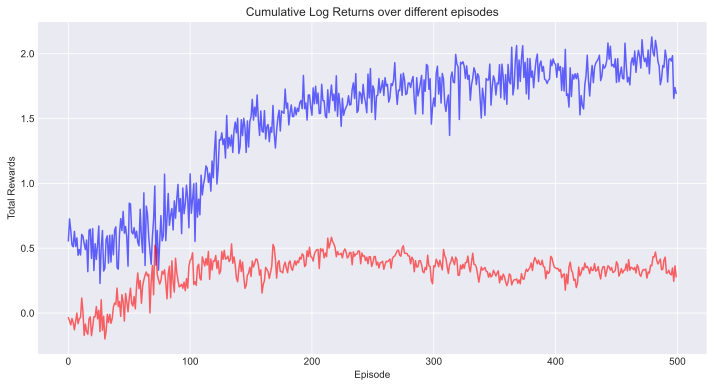

In [31]:
fig, axes = plt.subplots(figsize = (12,6))

axes.plot(train_rewards, c = 'blue', alpha = 0.6)
axes.plot(val_rewards, c = 'red', alpha = 0.6)

axes.grid()
axes.set_xlabel('Episode')
axes.set_ylabel('Total Rewards')
axes.set_title('Cumulative Log Returns over different episodes')